In [1]:
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport Compute_Jacobian_Anaheim
@pyimport tqdm

In [2]:
numNodes = Compute_Jacobian_Anaheim.numNodes;
numLinks = Compute_Jacobian_Anaheim.numLinks;
numODpairs = Compute_Jacobian_Anaheim.numODpairs;
numZones = Compute_Jacobian_Anaheim.numZones;
od_pairs = Compute_Jacobian_Anaheim.od_pairs;
link_list_js = Compute_Jacobian_Anaheim.link_list_js;
link_length_list = Compute_Jacobian_Anaheim.link_length_list;

In [3]:
require("../Julia_files/initia_data.jl");
require("prepare_data_Anaheim.jl");
require("extract_data_Anaheim.jl");
require("../Julia_files/tap_MSA.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");

In [4]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
                     norm(demandsDicToVec(demandsDict[0]));

In [5]:
fcoeffs = [1, 0, 0, 0, .15];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [6]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("./benchmark_data/Anaheim_net.txt", tapFlowDicDict[0])

Dict{(Int64,Int64),Arc} with 914 entries:
  (71,255)  => Arc(71,255,1800.0,0.5,2256.678299999999)
  (323,324) => Arc(323,324,5400.0,0.5,1101.5891999999994)
  (354,353) => Arc(354,353,5400.0,1.0,8.666300000000009)
  (60,230)  => Arc(60,230,9000.0,0.333333333,2184.6059000000014)
  (223,346) => Arc(223,346,1800.0,0.5,1407.6284)
  (147,146) => Arc(147,146,7200.0,0.763320942,3563.5880999999963)
  (337,33)  => Arc(337,33,12600.0,0.149068323,6579.954000000014)
  (366,365) => Arc(366,365,5400.0,0.5,1008.7476999999992)
  (390,375) => Arc(390,375,5400.0,2.0,0.0)
  (315,316) => Arc(315,316,5400.0,2.579924242,0.0)
  (198,197) => Arc(198,197,7200.0,0.152622883,6071.998799999999)
  (333,334) => Arc(333,334,5400.0,0.420075758,1499.1328999999978)
  (367,368) => Arc(367,368,5400.0,0.720075758,133.08839999999998)
  (244,339) => Arc(244,339,1800.0,0.5,1770.662099999999)
  (274,41)  => Arc(274,41,5400.0,1.0,0.0)
  (225,330) => Arc(225,330,1800.0,0.5,997.7932999999991)
  (49,369)  => Arc(49,369,5400.0,1.0,

In [7]:
deg = 6
c = 3.41
lam = 1.

coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);

In [8]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [9]:
demandsVecDict[1] = demandsDicToVec(demandsDict[1]);
objFunDict[1] = objF(demandsVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [10]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("./benchmark_data/Anaheim_net.txt", tapFlowDicDict[1]);

In [11]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [12]:
linkCostDicDict[1]["0"], link_length_list[1]

(1.1354317966878074,5280.0)

In [13]:
jacobiSpiessDict[1] = Compute_Jacobian_Anaheim.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[1]["$(i)"] for i=0:numLinks-1]);

In [14]:
# maximum number of iterations
N = 100;  

# Armijo rule parameters
rho = 2;
M = 10;

# search direction parameter
epsilon_1 = 0;

# stop criterion parameter
epsilon_2 = 1e-20;

In [ ]:
for iterNumber = 1:N
    
    l = iterNumber;
    
#     jacobDict[l] = jacobian(tapFlowVecDict[l], coeffs_dict[(deg, c, lam, l)], capacity, 
#     free_flow_time, numLinks, numODpairs, numRoutes, linkRoute, odPairRoute);
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], epsilon_1);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(objFunDict[l], demandsVecDict[l], coeffs_dict[(deg, c, lam, l)], 
    searchDirecDict[l], thetaMaxDict[l], rho, M);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("./benchmark_data/Anaheim_net.txt", tapFlowDicDict[l+1]);
        
#     coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[l+1]);
    coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[0]);

    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    jacobiSpiessDict[l+1] = Compute_Jacobian_Anaheim.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[l+1]["$(i)"] for i=0:numLinks-1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
    
    # stopping criterion
    if (objFunDict[l] - objFunDict[l+1]) / objFunDict[1] < epsilon_2
        break
    end
        
end

In [107]:
# update plots based on convergence rate
N = length(objFunDict)

# normalize objective function value
for l = 1:N
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [108]:
demandsVecDict

Dict{Any,Any} with 10 entries:
  0 => [1365.9,407.4,861.4,354.4,545.1,431.5,1.0,56.8,75.3,1.0,37.9,48.5,1.0,185…
  4 => [1164.591781504037,404.23815465622454,937.786328968864,319.4613617201452,…
  7 => [1165.2230079152187,404.5270086021004,937.9465192941152,319.9316373535340…
  9 => [1165.2262876349764,404.52858113689564,937.9473470226324,319.934098829802…
  2 => [1161.764638958007,402.99047481708334,936.6238596142723,316.990193752272,…
  3 => [1162.1829861856356,403.12446144828334,936.9084987863653,317.314636029890…
  5 => [1165.0205322777695,404.4301910109819,937.8953648265485,319.776564980081,…
  8 => [1165.2262876349764,404.52858113689564,937.9473470226324,319.934098829802…
  6 => [1165.2164099962818,404.5238645296844,937.9448647209317,319.9266994190426…
  1 => [1159.7511579124136,402.1957475379905,935.1744292993517,315.1384055767298…

In [109]:
norObjFunDict

Dict{Any,Any} with 9 entries:
  7 => 0.45652447007343333
  4 => 0.4812090075906815
  9 => 0.4563312752166876
  2 => 0.7757551789694249
  3 => 0.6325391963949581
  5 => 0.46662288954246395
  8 => 0.4563312752166876
  6 => 0.45713486207813914
  1 => 1.0

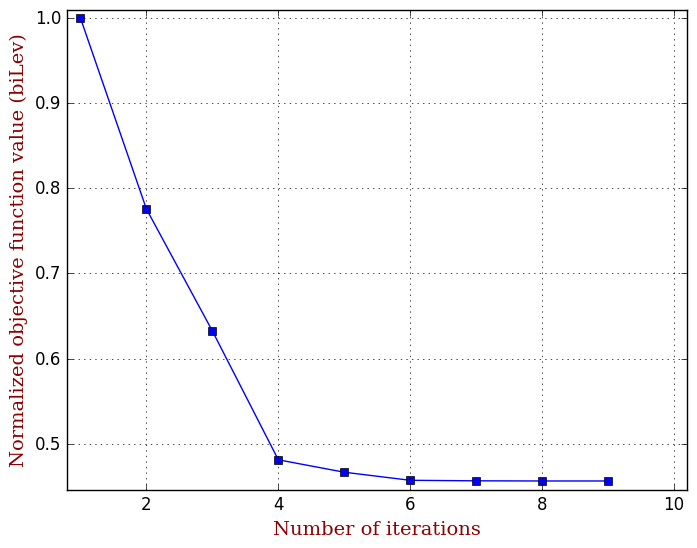

In [110]:
using PyPlot

iterNum = 1:N

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_Anaheim.pdf")

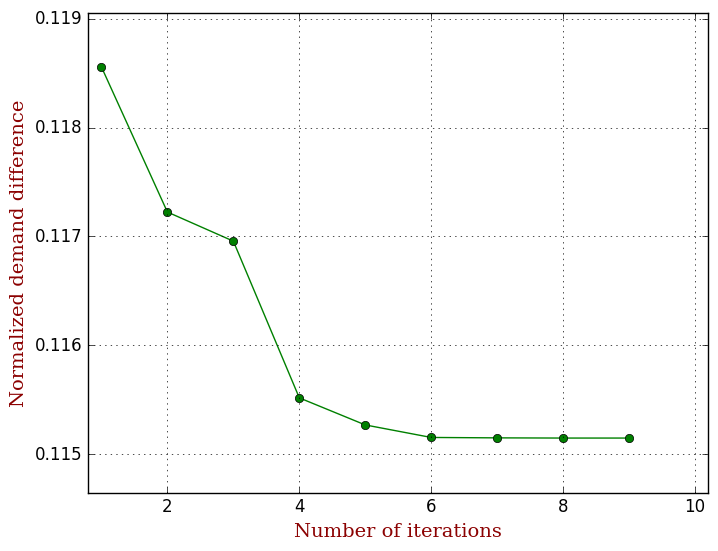

In [111]:
using PyPlot

iterNum = 1:N

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "o-g")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_Anaheim.pdf")

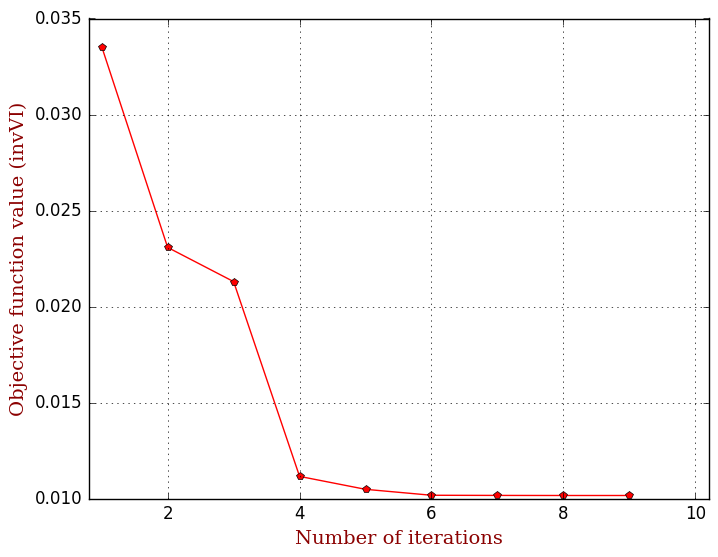

In [112]:
using PyPlot

iterNum = 1:N

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "p-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, N + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_Anaheim.pdf")

In [113]:
coeffs_dict

Dict{Any,Any} with 9 entries:
  (6,3.41,1.0,2) => [1.0,0.008411881349180635,-0.05836332745089019,0.12166981025…
  (6,3.41,1.0,6) => [1.0,0.007283126168897235,-0.04975345446451568,0.09780157669…
  (6,3.41,1.0,7) => [1.0,0.007283149623985895,-0.04975386376950502,0.09780349593…
  (6,3.41,1.0,5) => [1.0,0.007266652155551318,-0.04971844866084156,0.09794159755…
  (6,3.41,1.0,3) => [1.0,0.00883997039192778,-0.05802431818123704,0.111306941942…
  (6,3.41,1.0,9) => [1.0,0.007283251338078952,-0.04975446649396029,0.09780478058…
  (6,3.41,1.0,8) => [1.0,0.007283251338078952,-0.04975446649396029,0.09780478058…
  (6,3.41,1.0,4) => [1.0,0.0073004538732881355,-0.049886806056892934,0.098176507…
  (6,3.41,1.0,1) => [1.0,0.008731865717984276,-0.05042826351248569,0.08033374588…

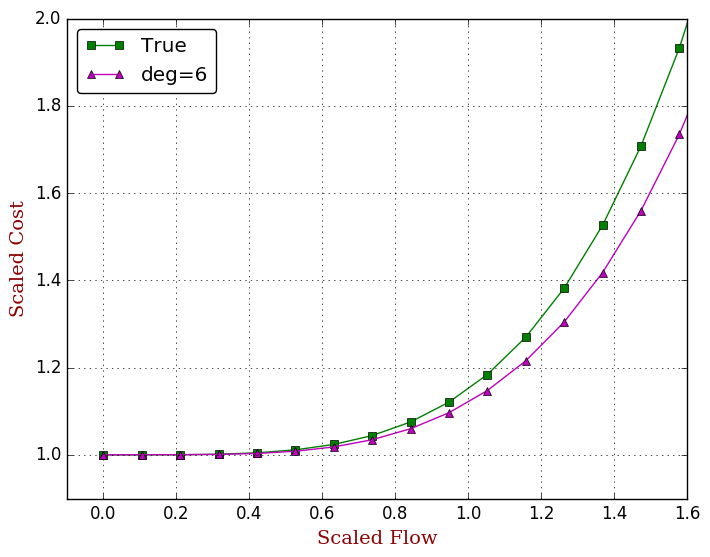

In [114]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Anaheim_iter_$(iterN).pdf")

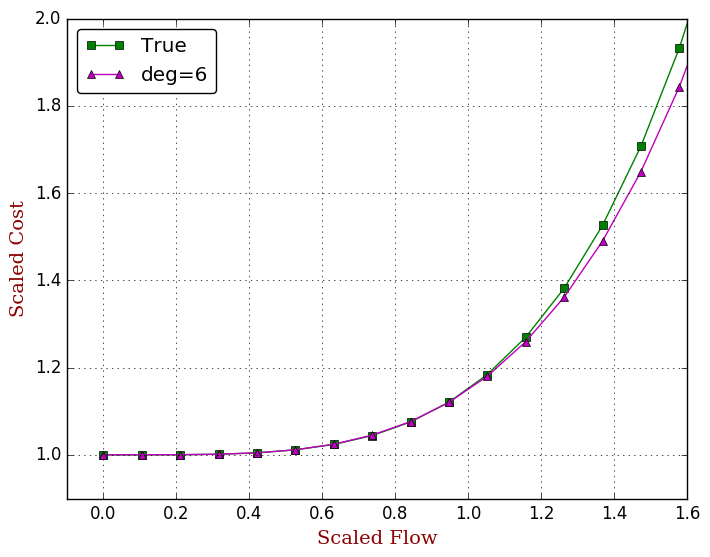

In [115]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Anaheim_iter_$(iterN).pdf")

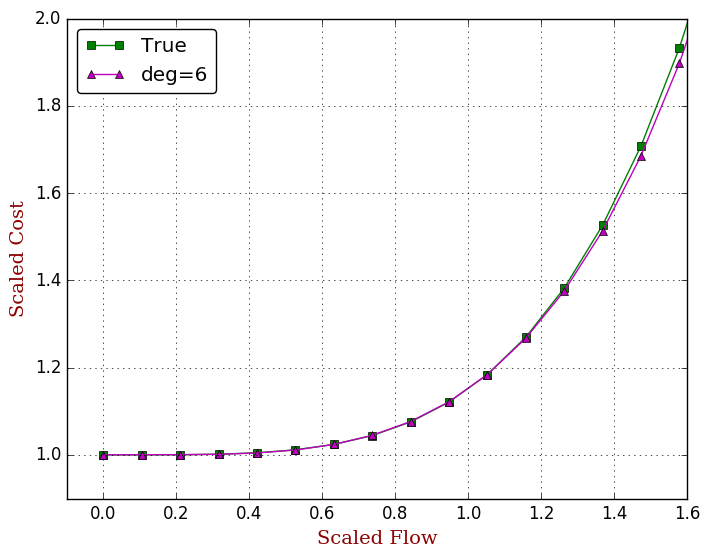

In [116]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Anaheim_iter_$(iterN).pdf")

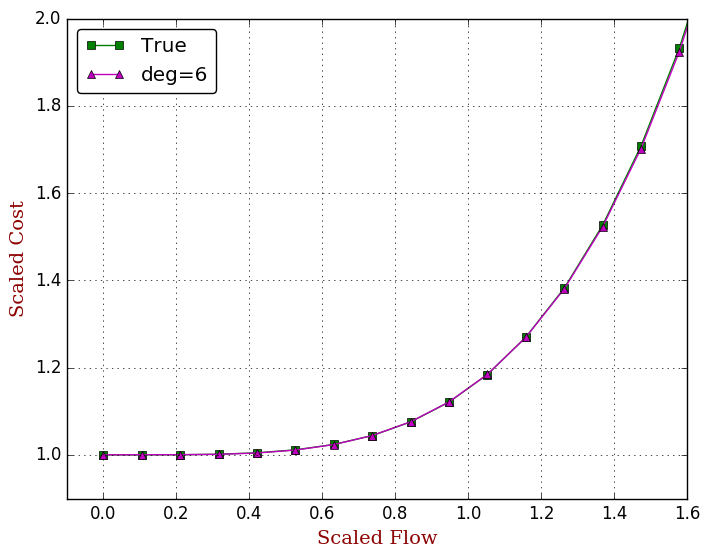

In [117]:
using PyPlot

iterN = N

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Anaheim_iter_$(iterN).pdf")

In [118]:
outfile = open("./results/norObjFunDict.json", "w")

JSON.print(outfile, norObjFunDict)

close(outfile)

In [119]:
outfile = open("./results/demandsDiffDict.json", "w")

JSON.print(outfile, demandsDiffDict)

close(outfile)

In [120]:
outfile = open("./results/objInvVIDict.json", "w")

JSON.print(outfile, objInvVIDict)

close(outfile)

In [121]:
outfile = open("./results/coeffs_dict.json", "w")

JSON.print(outfile, coeffs_dict)

close(outfile)

In [122]:
outfile = open("./results/demandsVecDict.json", "w")

JSON.print(outfile, demandsVecDict)

close(outfile)

In [123]:
outfile = open("./results/demandsDict.json", "w")

JSON.print(outfile, demandsDict)

close(outfile)

In [124]:
outfile = open("./results/tapFlowDicDict.json", "w")

JSON.print(outfile, tapFlowDicDict)

close(outfile)

In [125]:
outfile = open("./results/tapFlowVecDict.json", "w")

JSON.print(outfile, tapFlowVecDict)

close(outfile)